In [1]:
import os, sys
sys.path.append(os.path.abspath("../../../"))
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
url = 'https://github.com/nlapier2/PySensemakr/blob/main/sensemakr/data/darfur.csv?raw=true'
df = pd.read_csv(url)
df.head()

,wouldvote,peacefactor,peace_formerenemies,peace_jjindiv,peace_jjtribes,gos_soldier_execute,directlyharmed,age,farmer_dar,herder_dar,pastvoted,hhsize_darfur,village,female
0,0,1.000000,1,1,1,0,0,30,0,0,1,23,Abdel Khair,0
1,0,0.706831,0,1,1,0,0,20,1,0,1,5,Abdi Dar,1
2,1,0.000000,0,0,0,1,0,45,1,0,0,15,Abu Sorog,0
3,1,0.495178,1,0,0,0,1,55,0,0,0,9,Abu Dejaj,0
4,0,0.000000,0,0,0,1,1,25,1,0,1,7,Abu Dejaj,1


In [3]:
causal_graph = """dag {
age [pos="-0.197,-0.949"]
directlyharmed [pos="-0.165,0.301"]
farmer_dar [pos="-0.838,-0.982"]
female [pos="-1.841,-0.220"]
herder_dar [pos="0.710,-0.604"]
hhsize_darfur [pos="-2.044,0.164"]
pastvoted [pos="1.201,-0.226"]
peacefactor [outcome,pos="-0.048,0.900"]
village [pos="1.831,0.269"]
directlyharmed -> peacefactor
farmer_dar -> directlyharmed
female -> directlyharmed
herder_dar -> directlyharmed
hhsize_darfur -> directlyharmed
pastvoted -> directlyharmed
village -> directlyharmed
age -> pastvoted
female -> peacefactor
age -> peacefactor
pastvoted -> peacefactor
village -> peacefactor
farmer_dar -> peacefactor
herder_dar -> peacefactor
hhsize_darfur -> peacefactor
}
"""

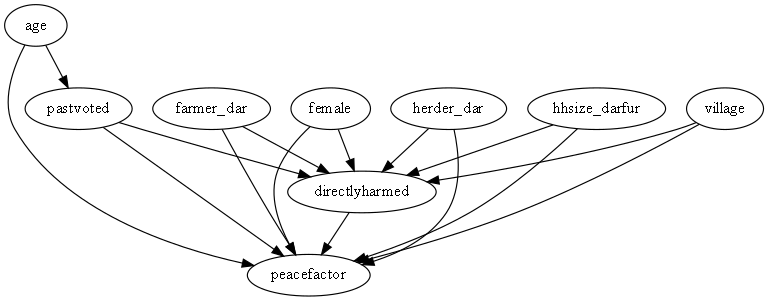

In [4]:
model= dowhy.CausalModel(
        data = df,
        graph=causal_graph,
        treatment="directlyharmed",
        outcome='peacefactor')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [5]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(Expectation(peacefactor|village,hhsize_darfur,female,herder_
d[directlyharmed]                                                             

                          
dar,pastvoted,farmer_dar))
                          
Estimand assumption 1, Unconfoundedness: If U→{directlyharmed} and U→peacefactor then P(peacefactor|directlyharmed,village,hhsize_darfur,female,herder_dar,pastvoted,farmer_dar,U) = P(peacefactor|directlyharmed,village,hhsize_darfur,female,herder_dar,pastvoted,farmer_dar)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [6]:
estimate = model.estimate_effect(identified_estimand,method_name="backdoor.linear_regression")

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}



Bad key "text.kerning_factor" on line 4 in
C:\Users\anush\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


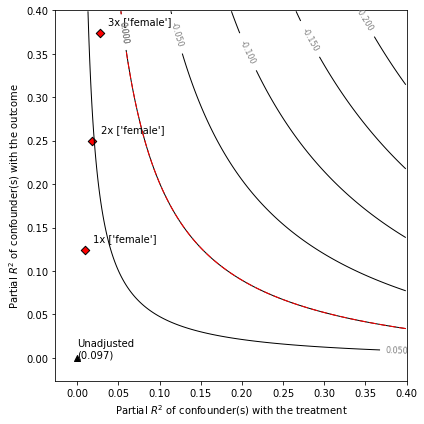

In [7]:
refute = model.refute_estimate(identified_estimand, estimate , method_name = "add_unobserved_common_cause",
                              simulated_method_name = "Carlos", benchmark_covariates = ["female"],
                              kd = [1,2,3], 
                              formula='peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + pastvoted + hhsize_darfur + female + village')

In [8]:
refute.stats

{'estimate': 0.09731581928495679,
 'standard error': 0.023256537809811115,
 'degree of freedom': 783,
 't_statistic': 4.184449984808258,
 'r2yd_x': directlyharmed    0.021873
 dtype: float64,
 'partial_f2': 0.022362224361892506,
 'robustness_value': 0.13877635389358906,
 'robustness_value_alpha ': 0.07625796554485817}

In [9]:
refute.bounds_result

,r2dz_x,r2yz_dx,treatment,adjusted_estimate,adjusted_se,adjusted_t,adjusted_lower_CI,adjusted_upper_CI
0,0.009164,0.124641,directlyharmed,0.075220,0.021873,3.438904,0.032283,0.118158
1,0.018329,0.249324,directlyharmed,0.052915,0.020350,2.600246,0.012968,0.092862
2,0.027493,0.374050,directlyharmed,0.030396,0.018670,1.628062,-0.006253,0.067045
